In [11]:
# HACKATHON: SHINKASEN TRAVEL EXPERIENCE
## Gabriel Bisco Reinato
### Version 2 
#### Last updated on 10-31-2024

# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import os

# XGboost
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Assign directory path
directory_path = os.getcwd()
# Print current directory
print(directory_path)

# Assign file names
file_name = [f for f in os.listdir('.') if f.endswith('.csv')]
# Sort the files in decreasing alphabetical order
file_name = sorted(file_name, reverse=True)
# Print csv files 
print(file_name)

C:\Users\gbisc\Documents\hackathon
['Traveldata_train.csv', 'Traveldata_test.csv', 'Surveydata_train.csv', 'Surveydata_test.csv']


In [13]:
for file in file_name:
    df = pd.read_csv(os.path.join(directory_path, file))
    print(file)
    print(f"\nShape: {df.shape}")
    print("\nNAN Count:")
    print(df.isnull().sum())

Traveldata_train.csv

Shape: (94379, 9)

NAN Count:
ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64
Traveldata_test.csv

Shape: (35602, 9)

NAN Count:
ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64
Surveydata_train.csv

Shape: (94379, 17)

NAN Count:
ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Servi

In [14]:
# Data extraction

# Read and merge sets

# Initialize empty lists to hold DataFrames for train and test
train_dataframes = []
test_dataframes = []

# Read each CSV file and append to the respective list with error handling
for file_name in file_name:
    try:
        df = pd.read_csv(os.path.join(directory_path, file_name))

        if 'Surveydata' in file_name:
            df = df.drop(columns=['ID'], errors='ignore')
        
        # Check if the file is train or test and append to the appropriate list
        if 'train' in file_name:
            train_dataframes.append(df)
        elif 'test' in file_name:
            test_dataframes.append(df)

    # Exception errors
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_name}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: The file '{file_name}' could not be parsed.")
    except Exception as e:
        print(f"An unexpected error occurred while reading '{file_name}': {e}")

# Combine Survey and Travel data for training
if train_dataframes:  # Only proceed if there are training DataFrames
    train_df = pd.concat([train_dataframes[0], train_dataframes[1]], axis=1)
    print(train_df.shape)
else:
    train_df = pd.DataFrame()  # Empty DataFrame if none found

# Combine Survey and Travel data for testing
if test_dataframes:  # Only proceed if there are testing DataFrames
   test_df = pd.concat([test_dataframes[0], test_dataframes[1]], axis=1)
   print(test_df.shape)
else:
    test_df = pd.DataFrame()  # Empty DataFrame if none found n

(94379, 25)
(35602, 24)


In [15]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class              

In [16]:
# Data manipulation
# Droping trivial columns
train_df = train_df.drop(['ID'], axis = 1)
id_column = test_df.pop('ID')

print(id_column.shape)

# Defining target variable
target_var = 'Overall_Experience'

(35602,)


In [17]:
# convert numerical data into categorical data
# definning bins and labels
# age
age_bins = [0, 15, 30, 45, 60, 100]
age_labels = ['0-15', '16-30', '31-45', '46-60', '61+']
# delay
delay_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,110,120, 1600]
delay_labels = ['0-10 min', '11-20 min', '21-30 min', '31-40 min', '41-50 min','51-60 min', '61-70 min', '71-80 min','81-90 min', ' 91-100 min','101-110','111-120','120+' ]
# trip distance
dist_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
dist_labels = ['0-1000 km', '1001-2000 km', '2001-3000 km', '3001-4000 km', '4001-5000 km', '5001-6000 km', '6000+']

# Training data
# Converting delays
train_df['Arrival_Delay_in_Mins'] = pd.cut(train_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
train_df['Departure_Delay_in_Mins'] = pd.cut(train_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
train_df['Travel_Distance'] = pd.cut(train_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
train_df['Age'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=True)

# Test Data
# Converting delays
test_df['Arrival_Delay_in_Mins'] = pd.cut(test_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
test_df['Departure_Delay_in_Mins'] = pd.cut(test_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
test_df['Travel_Distance'] = pd.cut(test_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
test_df['Age'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels, right=True)

In [18]:
# Shuffle the DataFrame (optional but recommended for randomness)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
# Accounting for NaN values
# Filling unkowns on the target variable by nearest neighbor
imputer = KNNImputer(n_neighbors=4)
train_df[[target_var]] = imputer.fit_transform(train_df[[target_var]])

# Separating target variable
y_train = train_df.pop(target_var)

In [22]:
# Convert all NaN values for unkowns
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(train_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in train_df[col].cat.categories:
                train_df[col] = train_df[col].cat.add_categories('Unknown')
            train_df[col].fillna('Unknown', inplace=True)
        else:
            train_df[col].fillna('Unknown', inplace=True)

for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(test_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in test_df[col].cat.categories:
                test_df[col] = test_df[col].cat.add_categories('Unknown')
            test_df[col].fillna('Unknown', inplace=True)
        else:
            test_df[col].fillna('Unknown', inplace=True)


In [23]:
print(train_df.shape)
print(test_df.shape)
print(y_train.shape)

(94379, 23)
(35602, 23)
(94379,)


In [24]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())
print()
print(y_train.isnull().sum())

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0


In [11]:
# Formatting data
# Cat formatting
x_train = pd.get_dummies(train_df, columns=train_df.columns, drop_first=True)
x_test = pd.get_dummies(test_df, columns= test_df.columns, drop_first=True)

# Align datasets to ensure shapes will be consistent
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

In [12]:
# Print variables shapes and head
print(x_train.head(1))
print()
print(x_train.shape)
print(x_test.shape)

   Gender_Male  Customer_Type_Loyal Customer  Age_16-30  Age_31-45  Age_46-60  \
0        False                          True      False      False       True   

   Age_61+  Type_Travel_Personal Travel  Travel_Class_Eco  \
0    False                        False             False   

   Travel_Distance_1001-2000 km  Travel_Distance_2001-3000 km  ...  \
0                         False                         False  ...   

   Cleanliness_Excellent  Cleanliness_Extremely Poor  Cleanliness_Good  \
0                  False                       False             False   

   Cleanliness_Needs Improvement  Cleanliness_Poor  Online_Boarding_Excellent  \
0                           True             False                      False   

   Online_Boarding_Extremely Poor  Online_Boarding_Good  \
0                           False                 False   

   Online_Boarding_Needs Improvement  Online_Boarding_Poor  
0                               True                 False  

[1 rows x 108 colum

In [13]:
# Initialize XGBoost model 
xgb_model = xgb.XGBClassifier(
    n_estimators=1500,
    max_depth=35,
    learning_rate=0.075,
    subsample=1.0,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42)

# Fit the model
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
# Predict on test data
y_pred = xgb_model.predict(x_test)

print(y_pred)
print(y_pred.shape)

[1 1 1 ... 1 1 0]
(35602,)


In [17]:
# Create a DataFrame
df = pd.DataFrame({
    "ID": id_column,
    "Overall_Experience": y_pred
})

In [18]:
# Save to CSV
df.to_csv("xgb_predictions.csv", index=False)

100%|===================| 75479/75503 [92:06<00:01]        

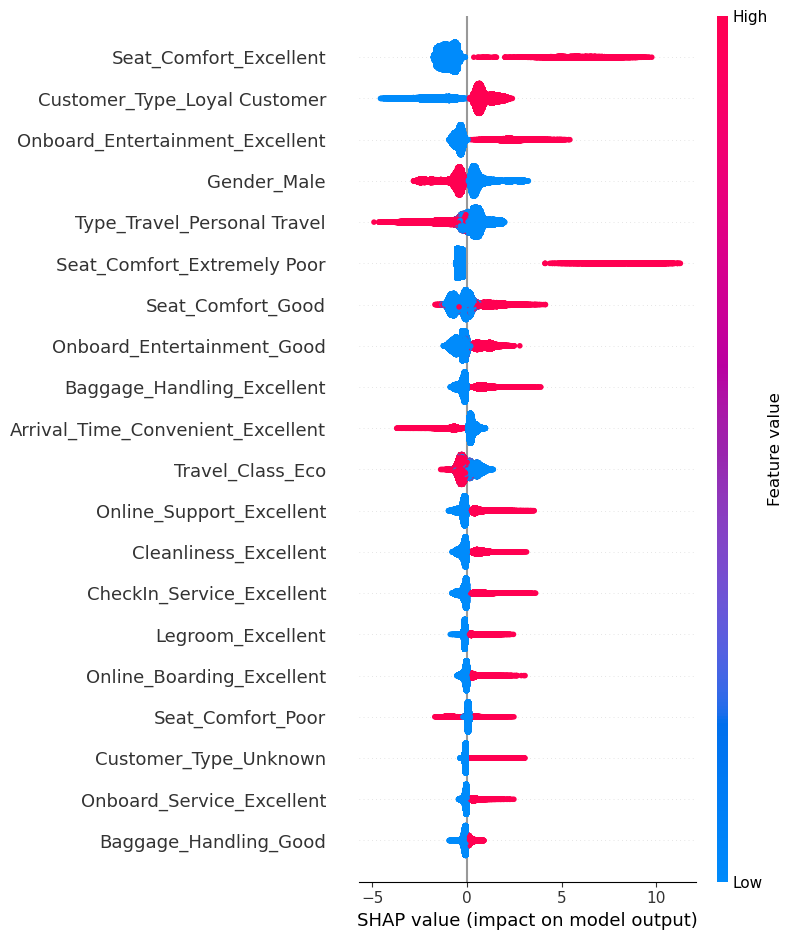

In [13]:
import shap
explainer = shap.Explainer(xgb_model, x_train)
shap_values = explainer(x_train)

# Plot only top 20 features with SHAP
shap.summary_plot(shap_values, x_train, max_display=20)

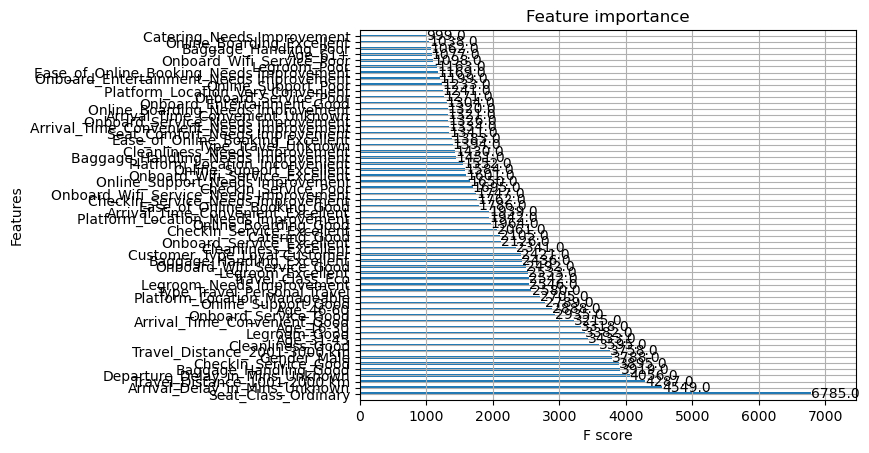

In [18]:
# Set max_num_features to the number of least important features you want to display
plot_importance(xgb_model, max_num_features=60, importance_type='weight', height=0.4)
plt.gca().invert_yaxis()  # This inverts the plot so that the least important features are at the top
plt.show()